In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%pip install ultralytics
#%pip install glasses-detector
%pip install pyfacer
%pip install timm
%pip install scikit-learn
%pip install Pillow
%pip install plotly
%pip install torchvision

import pandas as pd
from matplotlib import pyplot as plt
#import glasses_detector
import concurrent.futures
import os
import time
from PIL import Image
import matplotlib.image as mpimg
from sklearn.cluster import MiniBatchKMeans
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import KMeans
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
import torch
from torchvision.transforms.functional import to_pil_image
import facer
import shutil
import csv
import copy
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import plotly.graph_objects as go
import plotly.express as px
from io import BytesIO
import base64
import multiprocessing



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/16.4 MB 3.5 MB/s eta 0:00:05
   -- ------------------------------------- 0.8/16.4 MB 10.4 MB/s eta 0:00:02
   ------ --------------------------------- 2.8/16.4 MB 22.5 MB/s eta 0:00:01
   ------------- -------------------------- 5.5/16.4 MB 32.0 MB/s eta 0:00:01
   ---------------- ----------------------- 6.6/16.4 MB 35.2 MB/s eta 0:00:01
   ---------------- ----------------------- 6.6/16.4 MB 35.2 MB/s eta 0:00:01
   ---------------- ----------------------- 6.6/16.4 MB 35.2 MB/s eta 0:00:01
   ---------------- ----------------------- 6.6/16.4 MB

In [ ]:
# Directory principale del tuo progetto Waltico
project_dir = '/content/gdrive/My Drive/Progetto Computer Vision/'

In [3]:
# Directory locale del tuo progetto Waltico
project_dir = '/Users/dswal/Desktop/Progetto Computer Vision/Progetto Computer Vision/'

In [3]:
# Directory principale del tuo progetto Giansimone
project_dir = '/content/gdrive/MyDrive/Colab Notebooks/Computer Vision e Deep Learning/Progetto Computer Vision'

## Glasses Segmentation

In [9]:
class GlassesSegmentation:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._glasses_detector = glasses_detector.AnyglassesClassifier()

    def process_images(self):
        all_segments = {}
        # Processa ciascuna immagine nella directory dei risultati
        for filename in os.listdir(os.path.join(self._project_dir, 'data/images')):
            image_path = os.path.join(self._project_dir, 'data/images', filename)
            print(filename)
            image = self._load_image(image_path)
            print(image)

    def _load_image(self, image_path, csv_filename = 'glasses_per_image.csv'):
       # Verifica se la directory per il CSV esiste, altrimenti creala
        csv_dir = os.path.join(self._project_dir, 'results/csv')
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)

        csv_path = os.path.join(csv_dir, csv_filename)

        sus = self._glasses_detector (image_path)
        return sus


### Detection


In [6]:
class FaceDetection:
    def __init__(self, project_dir):
        self._project_dir = project_dir
        self._model_path = os.path.join(self._project_dir, 'data/models/yolov8l-face.pt')
        assert os.path.exists(self._model_path), "Il percorso del modello non è valido"
        self._model = YOLO(self._model_path)
        print("Inizializzazione...")

    def face_detection(self, input_dir='data/images', output_dir='results/faces'):
        # Prepara le directory di input e output
        input_dir = self._prepare_directory(input_dir)
        output_dir = self._prepare_directory(output_dir, create=True)
        self._clear_directory(output_dir)

        # Processa ciascuna immagine nella directory di input
        image_files = os.listdir(input_dir)
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(input_dir, image_file)
            results = self._model(image_path)
            self._process_results(results, image_path, output_dir, i, len(image_files))

        print("Processo concluso con successo")

    def _clear_directory(self,output_dir):
        # Verifica se la directory esiste
        if os.path.exists(output_dir):
            # Itera sui file nella directory e rimuovili
            for filename in os.listdir(output_dir):
                file_path = os.path.join(output_dir, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Errore durante la rimozione di {file_path}: {e}")
            print(f"Contenuto di {output_dir} svuotato.")
        else:
            print(f"La directory {output_dir} non esiste.")

    def _prepare_directory(self, dir_path, create=False):
        # Costruisce il percorso completo della directory
        full_path = os.path.join(self._project_dir, dir_path)
        if create and not os.path.exists(full_path):
            os.makedirs(full_path)
            print(f"Directory creata: {full_path}")
        return full_path

    def _process_results(self, results, image_path, output_dir, image_index, total_images):
        # Ritaglia e salva le immagini di ciascuna bounding box rilevata
        img = Image.open(image_path)
        for result in results:
            boxes = result.boxes.data
            for box_index, box in enumerate(boxes):
                cropped_img = self._crop_image(img, box)
                output_file = self._generate_output_filename(output_dir, image_index, total_images, box_index, len(boxes))
                cropped_img.save(output_file)

    def _crop_image(self, img, box):
        # Ritaglia l'immagine utilizzando le coordinate della bounding box
        x_min, y_min, x_max, y_max = box.tolist()[:4]
        return img.crop((x_min, y_min, x_max, y_max))

    def _generate_output_filename(self, output_dir, image_index, total_images, box_index, total_boxes):
        # Genera un nome di file per l'immagine ritagliata
        image_index_str = str(image_index).zfill(len(str(total_images)))
        box_index_str = str(box_index).zfill(len(str(total_boxes)))
        return os.path.join(output_dir, f'result_{image_index_str}_{box_index_str}.jpg')


In [13]:
fd = FaceDetection(project_dir)
fd.face_detection()

Inizializzazione...
Contenuto di /Users/dswal/Desktop/Progetto Computer Vision/Progetto Computer Vision/results/faces svuotato.

image 1/1 c:\Users\dswal\Desktop\Progetto Computer Vision\Progetto Computer Vision\data\images\Copia di 0.jpg: 960x960 1 face, 5545.0ms
Speed: 44.6ms preprocess, 5545.0ms inference, 20.1ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 c:\Users\dswal\Desktop\Progetto Computer Vision\Progetto Computer Vision\data\images\Copia di 1.jpg: 960x960 1 face, 5690.0ms
Speed: 22.8ms preprocess, 5690.0ms inference, 3.0ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 c:\Users\dswal\Desktop\Progetto Computer Vision\Progetto Computer Vision\data\images\Copia di 10.jpg: 960x960 2 faces, 5784.5ms
Speed: 20.8ms preprocess, 5784.5ms inference, 4.0ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 c:\Users\dswal\Desktop\Progetto Computer Vision\Progetto Computer Vision\data\images\Copia di 100.jpg: 960x960 1 face, 6919.4ms
Speed: 25.0ms prepr

## Face Segmenetation

In [14]:
class FaceSegmentation:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Inizializza i rilevatori e parser facciali
        self._face_detector = facer.face_detector('retinaface/mobilenet', device=self._device)
        self._face_parser = facer.face_parser('farl/lapa/448', device=self._device)

    def process_images(self):
        all_segments = {}
        directory = os.path.join(self._project_dir, "results/faces_facer")
        self._clear_directory(directory)
        # Processa ciascuna immagine nella directory dei risultati
        for filename in os.listdir(os.path.join(self._project_dir, 'results/faces')):
            image_path = os.path.join(self._project_dir, 'results/faces', filename)
            try:
                image = self._load_image(image_path)
                faces = self._detect_faces(image)
                self._visualize_faces(image, faces)
                faces = self._parse_faces(image, faces)
                seg_probs = faces['seg']['logits'].softmax(dim=1)
                all_segments[filename] = self._segment_faces(image, seg_probs, faces)
                self._save_visualization(image, seg_probs, filename)
            except Exception as e:
                print(f"Errore durante l'elaborazione di {filename}: {e}")
                continue  # Passa alla prossima immagine

        return all_segments

    def _clear_directory(self,output_dir):
            # Verifica se la directory esiste
            if os.path.exists(output_dir):
                # Itera sui file nella directory e rimuovili
                for filename in os.listdir(output_dir):
                    file_path = os.path.join(output_dir, filename)
                    try:
                        if os.path.isfile(file_path) or os.path.islink(file_path):
                            os.unlink(file_path)
                        elif os.path.isdir(file_path):
                            shutil.rmtree(file_path)
                    except Exception as e:
                        print(f"Errore durante la rimozione di {file_path}: {e}")
                print(f"Contenuto di {output_dir} svuotato.")
            else:
                print(f"La directory {output_dir} non esiste.")

    def _load_image(self, image_path):
        # Carica e converte l'immagine nel formato richiesto
        image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=self._device)
        return image

    def _detect_faces(self, image):
        # Rileva volti nell'immagine
        with torch.inference_mode():
            faces = self._face_detector(image)
        return faces

    def _parse_faces(self, image, faces):
        # Analizza i volti rilevati
        with torch.inference_mode():
            faces = self._face_parser(image, faces)
        return faces

    def _segment_faces(self, image, seg_probs, faces):
        # Segmenta i volti e i relativi componenti
        n_classes = seg_probs.size(1)
        segments = {}
        # Elenco delle classi da escludere
        exclude_classes = ['background', 'mouth']

        for face_id in range(seg_probs.size(0)):
            for class_id in range(n_classes):
                # Ottieni il nome della classe corrente
                class_name = faces['seg']['label_names'][class_id]
                # Salta la classe se è nell'elenco delle classi da escludere
                if class_name in exclude_classes:
                    continue

                mask = (seg_probs[face_id, class_id] > 0.5).float()
                if mask.sum() > 0:
                    if face_id not in segments:
                        segments[face_id] = []
                    segments[face_id].append([mask, class_name])

        return segments

    def _save_visualization(self, image, seg_probs, filename):
        # Salva la visualizzazione delle segmentazioni
        vis_seg_probs = seg_probs.argmax(dim=1).float() / seg_probs.size(1) * 255
        vis_img = vis_seg_probs.sum(0, keepdim=True)
        vis_img_pil = to_pil_image(vis_img.byte())
        directory = os.path.join(self._project_dir, "results/faces_facer")
        if not os.path.exists(directory):
            os.makedirs(directory)
        vis_img_pil.save(os.path.join(directory, f'result_{filename.split("_")[1]}_{filename.split("_")[2]}'), format='JPEG')

    def _visualize_faces(self, image, faces):
        # Mostra i volti rilevati
        facer.show_bchw(facer.draw_bchw(image, faces))


In [15]:
# Inizializza e processa le immagini per la segmentazione facciale
face_segmentation = FaceSegmentation(project_dir)

Contenuto di /Users/dswal/Desktop/Progetto Computer Vision/Progetto Computer Vision/results/faces_facer svuotato.


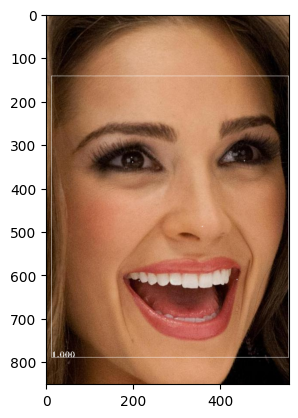

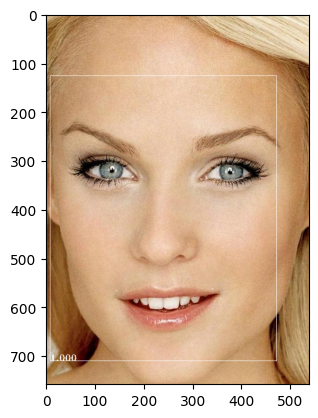

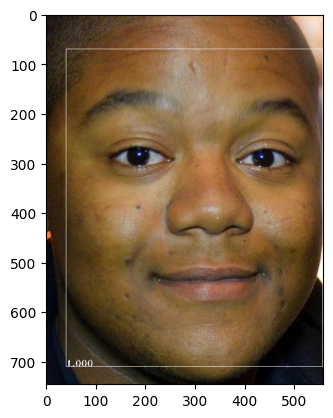

Errore durante l'elaborazione di result_02_1.jpg: 'image_ids'


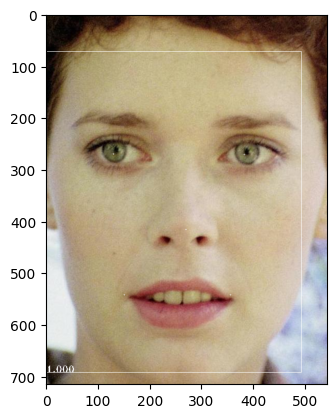

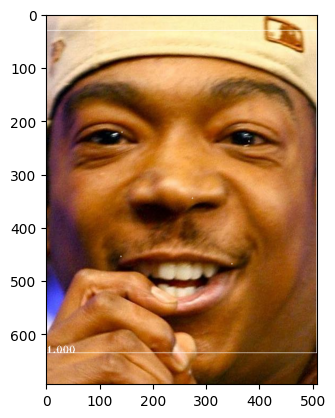

Errore durante l'elaborazione di result_04_1.jpg: 'image_ids'


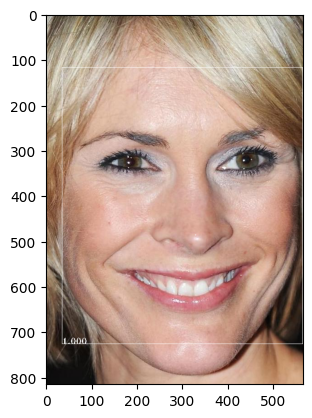

KeyboardInterrupt: 

In [16]:
segments = face_segmentation.process_images()

## Color Extraction

In [10]:
class ColorExtractor:
    def __init__(self, project_dir):
        # Imposta directory di progetto e dispositivo
        self._project_dir = project_dir
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def extract_dominant_colors(self, all_segments, normalize=True):
        start_time = time.time()
        dominant_colors = {}

        with concurrent.futures.ThreadPoolExecutor() as executor:
            future_to_segment = {
                executor.submit(self._process_file_segments, filename, segments): (filename, segments)
                for filename, segments in all_segments.items()
            }

            for future in concurrent.futures.as_completed(future_to_segment):
                filename, segments = future_to_segment[future]
                try:
                    file_dominant_colors = future.result()
                    dominant_colors.update(file_dominant_colors)
                except Exception as exc:
                    print(f'{filename} generated an exception: {exc}')

                if time.time() - start_time > 1200:
                    break

        return dominant_colors

    def _process_file_segments(self, filename, segments):
        file_dominant_colors = {}
        image_tensor = self._load_image(os.path.join(self._project_dir, 'results/faces', filename))
        for face_id, segment_list in segments.items():
            for mask, label_name in segment_list:
                colors = self._get_segmented_colors(image_tensor, mask)
                self._update_dominant_colors(file_dominant_colors, filename, face_id, label_name, colors)
        return file_dominant_colors

    def _load_image(self, image_path):
        # Carica e converte l'immagine nel formato richiesto
        image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=self._device)
        return image

    def _get_segmented_colors(self, image_tensor, mask):
        # Estrae i colori dai segmenti
        pixel_coords = torch.nonzero(mask)
        segmented_colors = [image_tensor[0, :, coord[0], coord[1]].cpu().numpy() for coord in pixel_coords]  # if not self._is_pixel_in_glasses_box(coord, glasses_boxes)]
        return np.array(segmented_colors) if segmented_colors else np.array([])

    def _update_dominant_colors(self, dominant_colors, filename, face_id, label_name, segmented_colors):
        # Elenco delle classi da escludere
        exclude_classes = ['background', 'imouth']
        # Salta la classe se è nell'elenco delle classi da escludere
        if label_name in exclude_classes:
            return dominant_colors

        if segmented_colors.size > 0:
            # Applica MiniBatchKMeans
            minibatch_kmeans = MiniBatchKMeans(n_clusters=3, batch_size=100).fit(segmented_colors)
            # Ottieni i centroidi
            centroids = minibatch_kmeans.cluster_centers_

            # Trova il colore più vicino a ciascun centroide
            closest_colors = []
            for centroid in centroids:
                distances = np.linalg.norm(segmented_colors - centroid, axis=1)
                closest_color = segmented_colors[np.argmin(distances)]
                closest_colors.append(closest_color)

            if filename not in dominant_colors:
                dominant_colors[filename] = {}
            dominant_colors[filename][label_name] = np.array(closest_colors)

        return dominant_colors

    '''def _is_pixel_in_glasses_box(self, coord, glasses_boxes):
        # Verifica se un pixel è dentro una bounding box degli occhiali
        return any(x_min <= coord[1] <= x_max and y_min <= coord[0] <= y_max for x_min, y_min, x_max, y_max in glasses_boxes)'''

    def save_dominant_colors_to_csv(self, dominant_colors, csv_filename='dominant_colors.csv'):
        # Verifica se la directory per il CSV esiste, altrimenti creala
        csv_dir = os.path.join(self._project_dir, 'results/csv')
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)

        csv_path = os.path.join(csv_dir, csv_filename)

        # Lista delle etichette (deve corrispondere alle etichette nei dati)
        labels = [
            'face', 'rb', 'lb', 're', 'le', 'nose', 'ulip', 'llip', 'hair'  # Rimosso 'background' e 'imouth'
        ]

        # Prepara l'intestazione del CSV
        columns = ['Filename']
        for label in labels:
            columns.extend([f'Color1-{label}', f'Color2-{label}', f'Color3-{label}'])

        # Salva i colori dominanti in un file CSV
        with open(csv_path, mode='w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(columns)

            for filename, labels_data in dominant_colors.items():
                    row = [filename]
                    for label in labels:
                        colors = labels_data.get(label, [np.nan, np.nan, np.nan])
                        row.extend(colors)
                    writer.writerow(row)


    def _are_colors_normalized(self, dominant_colors):
      # Controlla che tutti i valori siano normalizzati
      return all(
          (0 <= colors).all() and (colors <= 1).all()
          for faces in dominant_colors.values()
          for colors in faces.values()
      )

    def _normalize_colors(self, dominant_colors):
      # Normalizza i valori RGB nel range [0, 1]
      for filename, faces in dominant_colors.items():
              for label_name, colors in faces.items():
                  dominant_colors[filename][label_name] = colors / 255.0

    def show_colors(self, dominant_colors):
        # Creare una copia di dominant_colors per evitare modifiche all'originale
        dominant_colors_copy = copy.deepcopy(dominant_colors)

        # Normalizza i valori RGB nel range [0, 1] se non sono stati già normalizzati
        if not self._are_colors_normalized(dominant_colors_copy):
            self._normalize_colors(dominant_colors_copy)

        # Visualizza i colori normalizzati
        for filename, faces in dominant_colors_copy.items():
                for label_name, colors in faces.items():
                    print(f"\nFilename: {filename}, Label: {label_name}")
                    fig, ax = plt.subplots()
                    ax.imshow([colors], aspect='auto')
                    ax.axis('off')
                    plt.show()


In [ ]:
# Inizializza e estrai i colori dominanti dai segmenti facciali
color_extractor = ColorExtractor(project_dir)

In [ ]:
dominant_colors = color_extractor.extract_dominant_colors(segments)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
color_extractor.show_colors(dominant_colors)

NameError: name 'dominant_colors' is not defined

In [ ]:
# Utilizzo della funzione per salvare i dati in un file CSV
color_extractor.save_dominant_colors_to_csv(dominant_colors)

NameError: name 'dominant_colors' is not defined

## ColorClusterer

In [12]:
class ColorClusterer:
    def __init__(self, project_dir):
        self._project_dir = project_dir
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def _extract_colors(self, colors):
        colori = []
        for image_name, volti in colors.items():
            colori.append([])
            for parte, colori_parte in volti.items():
                colori[-1].append(colori_parte)
        return np.array(colori)

    def _visualize_clusters_3d(self, df, labels):
        tsne = TSNE(n_components=3, random_state=42)
        tsne_results = tsne.fit_transform(df.drop('cluster', axis=1))

        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        for cluster in range(12):
            indices = np.where(labels == cluster)[0]
            ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], tsne_results[indices, 2],
                       label=f'Cluster {cluster}')

        ax.set_title('t-SNE Visualization of Clusters (3D)')
        ax.legend()
        plt.show()

    def _visualize_clusters_2d(self, df, labels):
        # Visualizzazione utilizzando t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(df.drop('cluster', axis=1))

        # Plot
        plt.figure(figsize=(10, 8))
        for cluster in range(12):
            indices = np.where(labels == cluster)[0]
            plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Cluster {cluster}')
        plt.title('t-SNE Visualization of Clusters')
        plt.legend()
        plt.show()

    def cluster(self, colors, image_paths=None):
        colori = self._extract_colors(colors)
        flattened_faces = colori.reshape(colori.shape[0], -1)
        df = pd.DataFrame(flattened_faces)

        kmeans = KMeans(n_clusters=12, random_state=42)
        labels = kmeans.fit_predict(df)  # Perform KMeans clustering

        df['cluster'] = labels  # Add the 'cluster' column with cluster labels

        print("Cluster labels for each face:")
        print(labels)

        self._visualize_clusters_3d(df, labels)
        self._visualize_clusters_2d(df, labels)

In [ ]:
# Inizializza e estrai i colori dominanti dai segmenti facciali
color_clusterer = ColorClusterer(project_dir)

In [ ]:
color_clusterer.cluster(dominant_colors)

ValueError: n_samples=9 should be >= n_clusters=12.

### Parte sotto da non considerare

In [ ]:
# Percorso del modello
model_path = os.path.join(project_dir, 'yolov8l-face.pt')

# Assicurati che il percorso del modello sia corretto
assert os.path.exists(model_path), f"Il percorso del modello non è valido"
# Run inference on an image with YOLOv8
model = YOLO(model_path)
results = model(os.path.join(project_dir, 'Faces.jpg'))

AssertionError: Il percorso del modello non è valido

In [ ]:
for i, result in enumerate(results):
    boxes = result.boxes.data  # Boxes object for bounding box outputs

    result.save(filename='result.jpg')
    img = mpimg.imread('result.jpg')
    plt.imshow(img)
    # Itera attraverso tutte le bounding box individuate
    for j, box in enumerate(boxes):
        # Ottieni le coordinate della bounding box
        x_min, y_min, x_max, y_max, conf, cls = box.tolist()[:6]

        # Ritaglia l'area corrispondente dall'immagine originale
        img = Image.open(os.path.join(project_dir, 'Faces.jpg'))
        cropped_img = img.crop((x_min, y_min, x_max, y_max))

        # Salva l'immagine ritagliata
        directory = "faces"
        # Controllo se la cartella esiste, altrimenti la creo
        if not os.path.exists(directory):
            os.makedirs(directory)
        #shutil.rmtree(directory)
        cropped_img.save(os.path.join(directory,f'result_{i}_{"0" * (len(str(len(boxes))) - len(str(j)))}{j}.jpg'))